In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 6)

import os, sys, shutil
sys.path.append("..")

from lammpsrun import LAMMPS, Prism
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *
import pandas as pd

from ase import Atoms, units
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import surface
from ase.spacegroup import crystal, get_spacegroup

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
potential = "boda_manual_sub.reax"
print(cx1_out + '\n' + sim_path)

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


# Calculating siderite surfaces

In [2]:
working_dir = os.path.join(sim_path, 'siderite', 'distorted_surfaces_BODA')

In [4]:
# Assuming that the surfaces are identical for 
# structures that are identically labelled
ss_all_names = []

working_dir = os.path.join(sim_path, 'siderite', 'distorted_surfaces_BODA')
slab_set_files = [x for x in os.listdir(working_dir) if x.endswith('extxyz') and x.startswith('surface')]
slab_set_files_path = [os.path.join(working_dir, x) for x in slab_set_files]
slab_set_files = [x[7:-7] for x in slab_set_files]

for job_name, slab_file in zip(slab_set_files, slab_set_files_path):
    ss_all_names.append(job_name)

    slab_atoms = read(slab_file, format='extxyz')
    lower_boundary = min(slab_atoms.get_positions()[:, 2]) + 10
    upper_boundary = max(slab_atoms.get_positions()[:, 2]) - 10
    
    slab_calc = reaxff_params_generator(slab_atoms, job_name, write_input=True,
                                        input_fd=working_dir,
#                                         region="fixed block INF INF INF INF {:.2f} {:.2f} side in units box".format(lower_boundary, upper_boundary),
#                                         group="fixed_g region fixed",
                                        minimize=["1e-25 1e-25 100 10000"]*10,
                                        fix=["qeq_reaxc all qeq/reax 1 0.0 10.0 1e-10 reax/c dual"],
                                        potential=potential)    

ss_commands = [["mpiexec /rds/general/user/yx6015/home/lammps/build/lmp -sf omp -pk omp 8 -in {0}.lammpsin -screen none\n".format(x)] for x in ss_all_names]
ss_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                    '$PBS_O_WORKDIR/'+x+".lammps*"] for x in ss_all_names]

In [6]:
import time

ss_all_out = []
ss_all_err = []

for i in range(len(ss_all_names)):
    cur_qstat = !qstat
    
    while len(cur_qstat) > 45:
        time.sleep(60) # Wait for a minute
        cur_qstat = !qstat
        
    ss_PBS = PBS_Submitter(job_names=ss_all_names[i:i+1],
                           job_commands=ss_commands[i:i+1],
                           modules=["mpi/intel-2018", "intel-suite/2017.6"],
                           walltime="6:00:00",
                           proc_nodes=1,
                           proc_cpus=8,
                           proc_mpiprocs=1,
                           proc_threads=8,
                           memory=32,
                           source_files=ss_source_files[i:i+1])

    curr_dir = os.getcwd()
    
    os.chdir(working_dir)
    ss_out, ss_err = ss_PBS.run()
    os.chdir(curr_dir)
    
    ss_all_out.extend(ss_out)
    ss_all_err.extend(ss_err)
print(ss_all_out)
print(ss_all_names)

['127330.pbs', '127331.pbs', '127332.pbs', '127333.pbs', '127334.pbs', '127335.pbs', '127336.pbs', '127337.pbs', '127338.pbs', '127339.pbs', '127340.pbs', '127341.pbs', '127342.pbs', '127343.pbs', '127344.pbs', '127345.pbs', '127346.pbs', '127347.pbs', '127348.pbs', '127349.pbs', '127350.pbs', '127351.pbs', '127352.pbs', '127353.pbs', '127354.pbs', '127355.pbs', '127356.pbs', '127357.pbs', '127358.pbs', '127359.pbs', '127360.pbs', '127361.pbs', '127369.pbs', '127370.pbs', '127372.pbs', '127373.pbs', '127374.pbs', '127375.pbs', '127420.pbs', '127421.pbs', '127422.pbs', '127423.pbs', '127424.pbs', '127425.pbs', '127426.pbs', '127429.pbs', '127432.pbs', '127433.pbs', '127434.pbs', '127435.pbs', '127436.pbs', '127443.pbs', '127444.pbs', '127445.pbs', '127446.pbs', '127447.pbs', '127450.pbs', '127452.pbs', '127453.pbs', '127454.pbs', '127455.pbs', '127458.pbs', '127459.pbs', '127465.pbs', '127466.pbs', '127467.pbs', '127468.pbs', '127471.pbs', '127481.pbs', '127482.pbs', '127483.pbs', '1274

In [7]:
# Move all the log and error files over

for outfile, job_out in zip(ss_all_names, ss_all_out):
    shutil.move(os.path.join(working_dir, outfile + ".err"), os.path.join(ephemeral, job_out))
    shutil.move(os.path.join(working_dir, outfile + ".log"), os.path.join(ephemeral, job_out))

In [4]:
# Checking which runs have completed
ss_valid_names = ss_all_names.copy()
ss_valid_out = ss_all_out.copy()

# for outfile, job_out in zip(ss_all_names, ss_all_out):
#     err_file_name = os.path.join(ephemeral, job_out, outfile + ".err")
#     if os.path.isfile(err_file_name):
#         err_file_size = os.path.getsize(err_file_name)
#         if err_file_size > 0:
#             print(outfile, job_out, ': Terminated with errors')
#             ss_valid_names.pop(ss_valid_names.index(outfile))
#             ss_valid_out.pop(ss_valid_out.index(job_out))
            
#     else:
#         print(outfile, job_out, ': File not found')
#         ss_valid_names.pop(ss_valid_names.index(outfile))
#         ss_valid_out.pop(ss_valid_out.index(job_out))

In [5]:
import pandas as pd
dump_column_names = ['step', 'temp', 'press', 'cpu', 'pxx', 'pyy', 'pzz', 'pxy', 'pxz', 'pyz', 'ke', 'pe', 'etotal', 'vol', 'lx', 'ly', 'lz', 'atoms']
new_column_names = ['surface', 'stoichiometry', 'jobID', 'fileName', 'layers', 'thickness']
ss_all_df = pd.DataFrame(columns=dump_column_names + new_column_names)

for name, out in zip(ss_valid_names, ss_valid_out):
    slab = read(os.path.join(working_dir, name + ".extxyz"), format='extxyz')
    slab_thickness = np.percentile(slab.get_positions()[:, 2], q = [0, 100])
    slab_thickness = slab_thickness[1]-slab_thickness[0]

    new_data = dict.fromkeys(new_column_names)
    file_data = name.split('_')
    new_data['surface'] = file_data[0]
    new_data['jobID'] = out
    new_data['fileName'] = name
    new_data['layers'] = int(file_data[-1][1:])
    new_data['thickness'] = slab_thickness
    if len(file_data) == 2:
        new_data['stoichiometry'] = 'NA'
    elif 'N' in file_data[1]:
        new_data['stoichiometry'] = False
    elif 'S' in file_data[1]:
        new_data['stoichiometry'] = True
    else:
        new_data['stoichiometry'] = 'NA'

    log_reader = LAMMPS()
    log_path = os.path.join(ephemeral, out, 'log.lammps')
    if os.path.isfile(log_path):
        log_reader.read_lammps_log(lammps_log=log_path)
        if len(log_reader.thermo_content) == 0:
            continue
        init_data = log_reader.thermo_content[0]
        init_data['step'] = 'unrelaxed'
        final_data = log_reader.thermo_content[-1]
        final_data['step'] = 'relaxed'

        ss_all_df = ss_all_df.append({**new_data, **init_data}, ignore_index=True)
        ss_all_df = ss_all_df.append({**new_data, **final_data}, ignore_index=True)

Using Hao-Yeh's example:

$$ E_s=\frac{E_{slab}^{n}-n(E_{slab}^{n}-E_{slab}^{n-1})} {2A} $$

While the thickness of slab reaches an adequate value, where the central atom positions are fixed,
$(E^n_{slab} - E^{n-1}_{slab})$ should converge to $𝐸_{bulk}$

In [6]:
stoichiometric_df = pd.DataFrame()
for label, df in ss_all_df.groupby(by=['surface', 'stoichiometry', 'step']):
    surface = label[0]
    stoichiometry = label[1]
    if stoichiometry:
        df_sorted = df.sort_values('layers').reset_index(drop=True)
        df_sorted.layers = pd.to_numeric(df_sorted.layers)
        df_sorted['area'] = df_sorted.lx * df_sorted.ly
        df_sorted['Es'] = (df_sorted.pe - df_sorted.pe.diff() * df_sorted.atoms/df_sorted.atoms.diff()) / (2*df_sorted.area.median())
        df_sorted['Es_SI'] = df_sorted['Es']  * units.kcal /units.mol / units.J * (units.m)**2
        df_sorted['Ebulk'] = df_sorted.pe.diff() / df_sorted.atoms.diff()
#         df_sorted['Ebulk_SI'] = df_sorted['Ebulk']  * units.kcal /units.mol / units.J
        stoichiometric_df = stoichiometric_df.append(df_sorted.copy(), ignore_index=True)
stoichiometric_df.sort_values(by=['surface', 'step', 'layers'], inplace=True)

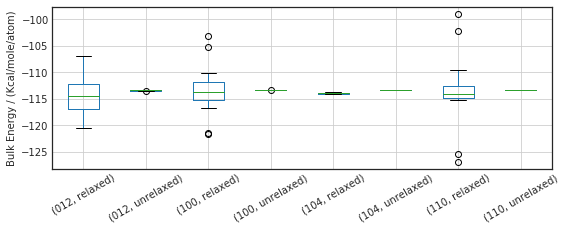

In [7]:
plt.style.use("seaborn-white")
ax = stoichiometric_df.boxplot('Ebulk', by=['surface', 'step'], rot = 30, figsize=(8,3.3))

ax.set_ylabel("Bulk Energy / (Kcal/mole/atom)")
ax.set_xlabel(None)
ax.set_title(None)
plt.suptitle(None)
plt.tight_layout()
plt.savefig("bulk_energy_box.eps", dpi=400, bbox_inches="tight")
plt.show()

012 0.9681244268326511 0.002574774871250202
100 2.771210516159364 8.33742867429873e-05
104 0.31662846740809975 0.00022192905732441062
110 2.4699478034793314 0.0006070226792276634


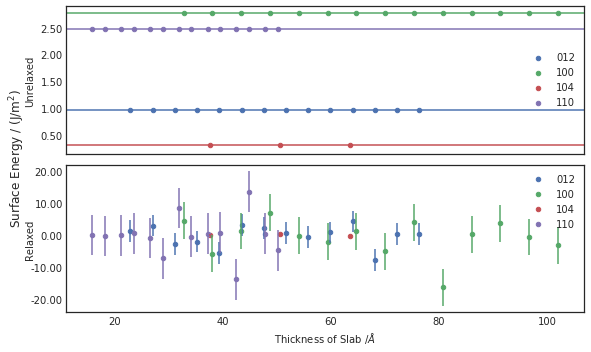

In [9]:
plt.style.use("seaborn-white")

fig, axes = plt.subplots(2,1, figsize=(8,5), sharex=True)
seaborn_colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']
seaborn_colors = np.array([[x, x] for x in seaborn_colors]).flatten()

for (label, df), c in zip(stoichiometric_df.groupby(by=['surface', 'step']), seaborn_colors):
    cur_ax = axes[0]
    surface = label[0]
    step = label[1]
    yerr = None
    
    if step == 'final':
        cur_ax = axes[1]
        yerr = df.Es_SI.std()
        
    df.plot(x='thickness', y='Es_SI', kind='scatter', ax=cur_ax, yerr = yerr, color=c, label = surface)
    
    Es_mean = df.Es_SI[abs(df.Es_SI - df.Es_SI.mean()) < df.Es_SI.std()][-2:].mean()
    if step == 'initial':
        cur_ax.axhline(Es_mean, color=c)
        print(surface, Es_mean, df.Es_SI.std())

axes[0].set_ylabel("Unrelaxed")
axes[1].set_ylabel("Relaxed")

axes[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
axes[0].yaxis.set_label_coords(-0.06,0.5)
axes[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
axes[1].yaxis.set_label_coords(-0.06,0.5)

fig.text(-0.02, 0.55, 'Surface Energy / (J/m$^2$)', va='center', rotation='vertical', size=12)

plt.xlabel(r"Thickness of Slab /$\AA$")

fig.tight_layout()
# fig.subplots_adjust(left=0.3)
fig.savefig("surface_energies.eps", dpi=400, bbox_inches="tight")
plt.show()